#<b>Malaria Detection - Final Report

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>

###<b> Mount Drive

In [ ]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###<b>Load Libraries</b>

In [ ]:
#Import libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Process Data</b>

<b>Load Data

In [ ]:
#Store the path of the data file from the Google drive
path = '/content/drive/MyDrive/Colab Notebooks/Capstone/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
#Store the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

<b>Convert list to arrary

In [ ]:
#Run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Open each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resize each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Convert images to arrays and append that array to the empty list defined above
            train_images.append(np.array(image))

            #Create labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#Store the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
#Run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Open each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resize each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Convert images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Create labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

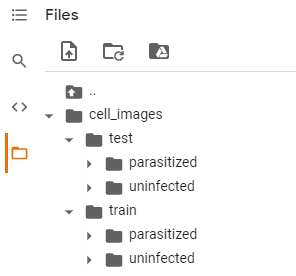

#### **Observations and insights:**
- The extracted folder has different sub-folders for training and test data which further contains the images for parasitized and uninfected cells within the respective folder name. 
- All images are resized to 64 by 64 pixels and converted to 4D arrays so that they will have the same dimensions to be used as an input for the convolutional neural network. 
- The labels ofr each images are also created for both types of images allowing us to train and test the model. 

### <b>Check Data</b>

#### **Data shape**


In [ ]:
#Shape of images
print('Train images shape:', train_images.shape)
print('Test images shape:', test_images.shape)

#Shape of labels 
print('Train label shape:', train_labels.shape)
print('Test label shape:', test_labels.shape)

Train images shape: (24958, 64, 64, 3)
Test images shape: (2600, 64, 64, 3)
Train label shape: (24958,)
Test label shape: (2600,)


#### **Minmum and maximum pixel intensity**

In [ ]:
#Min and Max of the training and test images
print("Minimum pixel value of images in the training set:", np.min(train_images))
print("Maximum pixel value of images in the training set:", np.max(train_images))
print("Minimum pixel value of images in the test set:", np.min(test_images))
print("Maximum pixel value of images in the test set:", np.max(test_images))

Minimum pixel value of images in the training set: 0
Maximum pixel value of images in the training set: 255
Minimum pixel value of images in the test set: 0
Maximum pixel value of images in the test set: 255


#### **Class distribution**

In [ ]:
#Count unquie events in training and test labels in both classes
unique, counts = np.unique(train_labels, return_counts=True)
print('Uninfected in training set:', counts[0])
print('Parasitized in training set:', counts[1])

unique_test, counts_test = np.unique(test_labels, return_counts=True)
print('Uninfected in test set:', counts_test[0])
print('Parasitized in test set:', counts_test[1])

Uninfected in training set: 12376
Parasitized in training set: 12582
Uninfected in test set: 1300
Parasitized in test set: 1300


([<matplotlib.patches.Wedge at 0x7fba599e7f10>,
 [Text(8.082668874372532e-17, 1.32, '0'),
  Text(-2.4248006623117594e-16, -1.32, '1')],
 [Text(4.4087284769304716e-17, 0.72, '50.0%'),
  Text(-1.3226185430791412e-16, -0.72, '50.0%')])

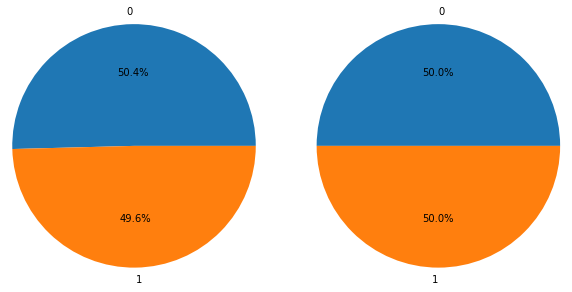

In [ ]:
#Graph training and test labels to visualize the distribution of each clasee
df_train_labels = pd.DataFrame(train_labels)
df_test_labels = pd.DataFrame(test_labels)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) #ax1,ax2 refer to the two pies
ax1.pie(df_train_labels.value_counts(), autopct = '%.1f%%', radius = 1.2, labels = ['0', '1'])
ax2.pie(df_test_labels.value_counts(), autopct = '%.1f%%', radius = 1.2, labels = ['0', '1'])


#### **Visualize images**

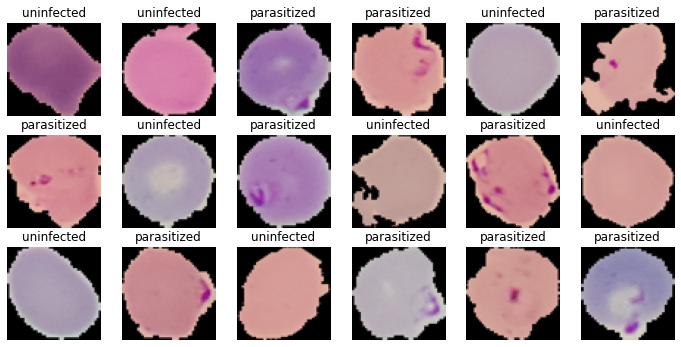

In [ ]:
#Display 18 randomly selected images in the training set to insepct the images and their corresponding labels
np.random.seed(42)
plt.figure(1 , figsize = (12 , 12))

for n in range(1, 19):
    plt.subplot(6, 6, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

#### **Observations and insights:**
- Images in the training and test sets have the same dimensions - 64 pixels by 64 pixels in 3 channels (green, red, and blue) 
- There are 24,958 images in the training set and 2,600 images in the test set. 
- The number of images and labels match in both data sets. 
- The range of pixel values for both training and test set is 0 to 255, indicating that the images are likely to be 8 bit RGB format, which is standard for brightfield images. 
- Pixel value = 0 means there is no intensity information of a given pixel, where the brightest pixel has count of 255. Signal beyond the range cannot be captured.
- Uninfected cells are labeled as 1, while the parasitised cells are labeled as 0. Both labels are evenly distributed in the training and test sets. No class inbalance issue.
- Red blood cells have different shape and hue. Uninfected cells have relatively even color and intensity distribution; whiel the parasitized cells have dark purple (more red than blue) patches within the cell.
- The randomly selected images showed that there might be some mis-labeled images in the training set, which might affect the robustness of the model. However, data validation at this level is beyond the scope of this project - we just need to be mindful about the possibility of incorrectly labeled data. This informaiton would also help us to explain the model accuracy moving forward.

###<b>Normalize the images

In [ ]:
#Normalize the training and test images
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

#### **Observations and insights:**
- Normalize the training and test images so they will have the scale of 0 to 1

###<B>One Hot Encoding on the train and test labels

In [ ]:
#Encode training labels to catagorical classes
train_labels=to_categorical(train_labels,2)

#Encode test labels in the same way
test_labels=to_categorical(test_labels,2)

#### **Observations and insights:**
- Encode the labels to binary classes for model building - 0 is unfected and 1 is parasitized. 

###<b> Data Exploration

#### **Mean images**

**Mean image function**

In [ ]:
#Function to find the mean
def find_mean_img(full_mat, title):
    # Calculate average
    mean_img = np.mean(full_mat, axis = 0)[0]
    # Reshape it back to a matrix
    plt.imshow(mean_img)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

**Mean image of parasitized cells**

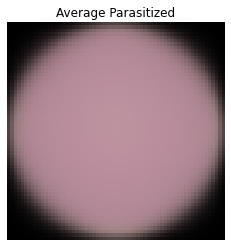

In [ ]:
#Create a list to store the parasitized data
parasitized_data=[]                                
for img, label in zip(train_images, train_labels):
        if label==1:
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean

**Mean image of uninfected cells**

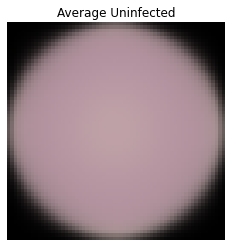

In [ ]:
 #Create a list to store the parasitized data
uninfected_data=[]                               
for img, label in zip(train_images, train_labels):
        if label==0:
              uninfected_data.append([img])          

uninfected_mean = find_mean_img(np.array(uninfected_data), 'Uninfected')   # find the mean

**Observations and insights:**
- Due to how the cells are cropped, the backgoup intensity is zero.
- The average image of parasitized cells has slightly more purpule hue with some blurry purple patches, while the uninfected cells appaer to be pink with more uniformed distribution.
- However, the difference between the images of mean parasitized cells and uninfected cells is minimum. Averaging all images may not a good chocie as parasites are not always in the same location within an infected cell. 

In [ ]:
gbx=[]  ## to hold the blurred images
for i in np.arange(0,train_images.shape[0],1):
  b= cv2.GaussianBlur(train_images[i], (5, 5), 0)
  gbx.append(b)
gbx=np.array(gbx)

In [ ]:
viewimage=np.random.randint(1,train_images.shape[0],10)
fig,ax=plt.subplots(1,10,figsize=(12,12))
for t,i in zip(range(10),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

#### **Gaussian blurring images**

**Gaussian blur on training images**

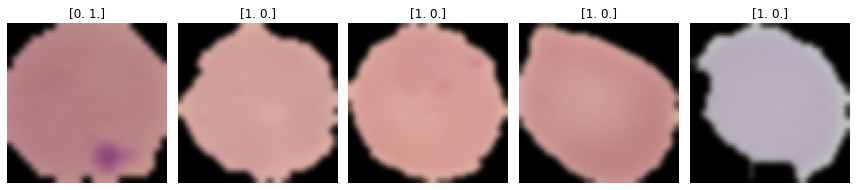

In [ ]:
import cv2
##Hold the blurred images
gbx=[]  
for i in np.arange(0,train_images.shape[0],1):
  b= cv2.GaussianBlur(train_images[i], (5, 5), 0)
  gbx.append(b)
gbx=np.array(gbx)

viewimage=np.random.randint(1,train_images.shape[0],10)
fig,ax=plt.subplots(1,5,figsize=(12,12))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

**Gaussian blur on test images**

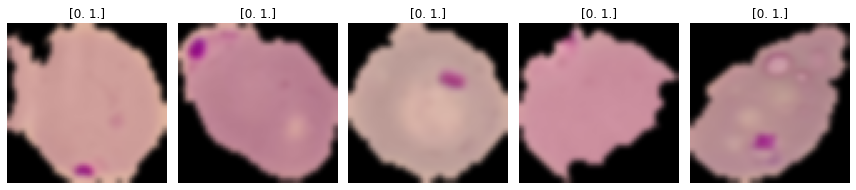

In [ ]:
gbx=[]
for i in np.arange(0,test_images.shape[0],1):
  c= cv2.GaussianBlur(test_images[i], (5, 5), 0)
  gbx.append(c)
gbx=np.array(gbx)

viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(12,12))
for t,i in zip(range(5),viewimage):
  Title=test_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

**Observations and insights:**
- Gaussian bluring is not very helpful to enhance the difference between the parasitized cells and the uninfected ones. 
- There is very little variation/ structure within an unifected cells but pronounced patches within the parasitized cells. Perhaps converting RGB images to HSV would be more useful. Will explore this in the model building. 

### **Base Model**
Build the Base Model of 3 CONV layers with batch normalization and ReLu activation for the output layer

#### **Import the required libraries**

In [ ]:
#Clear backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()

#Fix the seed for random number generators to ensure the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

#### **Build the model**
1.   Feature Extraction: 
Building three sequential layers to extract features from input images. For each layer, using 2D convolution with ReLu activation, then Max Pooling to reduce the number of parameters at each layer. 
2.   Classification:
Flattening the matrix into vector and feed it into a dense neural network. With the fully connected layers, combining the features to create the model with softmax activation function to classify the outputs as unifected or parasitized. Dropout regualization to avoid overfitting.


 

In [ ]:
#Create a sequential model
BaseModel=Sequential()

#Convoltion layer 1 
BaseModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
BaseModel.add(MaxPooling2D(pool_size=2))
BaseModel.add(Dropout(0.25))
#Convolution layer 2
BaseModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
BaseModel.add(MaxPooling2D(pool_size=2))
BaseModel.add(Dropout(0.25))
#Convolution layer 3
BaseModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
BaseModel.add(MaxPooling2D(pool_size=2))
BaseModel.add(Dropout(0.25))

#Flatten input layers 
BaseModel.add(Flatten())

#Fully connected dense layer 1, with ReLu activation, batch normalization, and regrularization with dropout 
BaseModel.add(Dense(512,activation="relu"))
BaseModel.add(BatchNormalization())
BaseModel.add(Dropout(0.5))
#Output layer neurons with Softmax activation function
BaseModel.add(Dense(2,activation="softmax"))

BaseModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

#### **Compile the model**

In [ ]:
BaseModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b>Use Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train the model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
%time history_BaseModel=BaseModel.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)


Epoch 1/20
624/624 [==============================] - 21s 15ms/step - loss: 0.6545 - accuracy: 0.6581 - val_loss: 0.7387 - val_accuracy: 0.6314
Epoch 2/20
624/624 [==============================] - 8s 14ms/step - loss: 0.1921 - accuracy: 0.9340 - val_loss: 0.1611 - val_accuracy: 0.9507
Epoch 3/20
624/624 [==============================] - 9s 15ms/step - loss: 0.1358 - accuracy: 0.9524 - val_loss: 0.1371 - val_accuracy: 0.9834
Epoch 4/20
624/624 [==============================] - 8s 14ms/step - loss: 0.1185 - accuracy: 0.9581 - val_loss: 0.0965 - val_accuracy: 0.9774
Epoch 5/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1074 - accuracy: 0.9615 - val_loss: 0.0622 - val_accuracy: 0.9858
Epoch 6/20
624/624 [==============================] - 9s 15ms/step - loss: 0.0948 - accuracy: 0.9693 - val_loss: 0.0580 - val_accuracy: 0.9846
Epoch 7/20
624/624 [==============================] - 9s 14ms/step - loss: 0.0898 - accuracy: 0.9705 - val_loss: 0.0489 - val_accuracy: 0.984

#### **Evaluating the model**

<b> Model accuracy on the test data

In [ ]:
%time accuracy_BaseModel = BaseModel.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:', accuracy_BaseModel[1])

82/82 [==============================] - 1s 8ms/step - loss: 0.0605 - accuracy: 0.9796
CPU times: user 665 ms, sys: 67.8 ms, total: 732 ms
Wall time: 783 ms

 Test_Accuracy: 0.9796153903007507


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



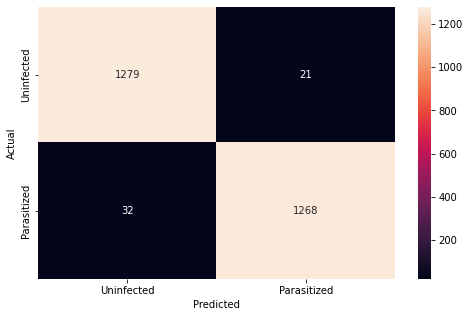

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = BaseModel.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [ ]:
def plot_accuracy(history_BaseModel):
    N = len(history_BaseModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_BaseModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_BaseModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

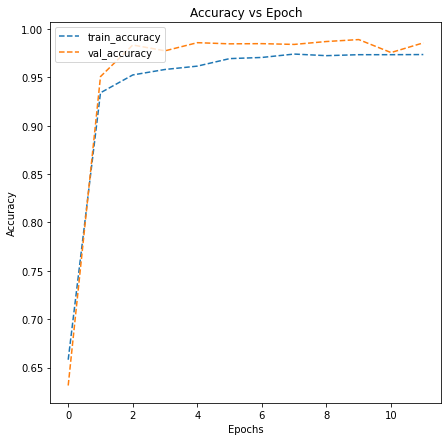

In [ ]:
plot_accuracy(history_BaseModel)

<b>Deeper dive on wrong predictions

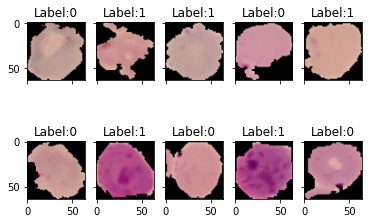

In [ ]:
#Predict values from validation images
y_pred = BaseModel.predict(test_images)

#Convert prediction class to one hot vector
y_pred_class = np.argmax(y_pred,axis = 1) 

#Convert validation label to one hot vector
y_true_class = np.argmax(test_labels,axis = 1)

#Difference between predicted label and the true label
err = (y_pred_class != y_true_class)
err_index=[]
for i in range(0,len(err)):
  if err[i]:
    err_index.append(i)
    
y_pred_class_err = y_pred_class[err]
y_pred_err = y_pred[err]
y_true_err = y_true[err]
x_val_err = test_images[err]

def display_err(err_index,img_err,pred_err,y_true_err):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            err = err_index[n]
            ax[row,col].imshow((img_err[err]).reshape((64,64,3)))
            ax[row,col].set_title("Label:{}".format(y_true_err[err]))
            n += 1
#Probabilities of the wrong predicted numbers
y_pred_err_prob = np.max(y_pred_err,axis = 1)
#Predicted probabilities of the true values in the error set
true_prob_err = np.diagonal(np.take(y_pred_err, y_true_err, axis=1))
#Difference between the probability of the predicted label and the true label
delta_err = y_pred_err_prob - true_prob_err
#Sorted list of the delta prob errors
sorted_delta_err = np.argsort(delta_err)
#Top 10 errors 
top_err = sorted_delta_err[-10:]
#Show the top 10 errors
display_err(top_err, x_val_err, y_pred_class_err, y_true_err)

#### **Observations and insights:**
- The base model has 3 sequential 2D convolutional layers to extract features from input images and two fully connected layer with dense neural network. Regualize with dropout at each layer to avoid overfitting. 
- Total parameters: 1,060,834.
- Model training time: 116 sec
- Model accuracy: 0.9796
- Test accuracy running time: 1 sec
- Precision: 0.99
- Recall: 0.97
- f1-score: 0.98
- Both training and test accuracy converage quickly after 2 epochs and plateau at round 0.98, suggesting a robust, generalized model. 
- Review the wrong prediction in the test images - it appears that the top 10 erroneous preditions are due to the fact that these images are incorrectly labeled. This result further supports the previous observation where some of the images are  mis- or ambiguiously labeled. 


### **Sigmoid Model**
Fine tune the base model by using sigmoid activation in the output layer

#### **Importing the required libraries**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

#### **Building the model**
1.   Feature Extraction: 
Building three sequential layers to extract features from input images. For each layer, using 2D convolution with ReLu activation, then Max Pooling to reduce the number of parameters at each layer. 
2.   Classification:
Flattening the matrix into vector and feed it into a dense neural network. With the fully connected layers, combining the features to create the model with Sigmoid activation function to classify the outputs as unifected or parasitized. Dropout regualization to avoid overfitting.


 

In [ ]:
#creating sequential model
SigmoidModel=Sequential()

#convoltion layer 1 
SigmoidModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
SigmoidModel.add(MaxPooling2D(pool_size=2))
SigmoidModel.add(Dropout(0.25))
#convolution layer 2
SigmoidModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
SigmoidModel.add(MaxPooling2D(pool_size=2))
SigmoidModel.add(Dropout(0.25))
#convolution layer 3
SigmoidModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
SigmoidModel.add(MaxPooling2D(pool_size=2))
SigmoidModel.add(Dropout(0.25))

SigmoidModel.add(Flatten())
#fully connected dense layer 1
SigmoidModel.add(Dense(512,activation="relu"))
SigmoidModel.add(BatchNormalization())
SigmoidModel.add(Dropout(0.5))
#output layer neurons 
SigmoidModel.add(Dense(2,activation="sigmoid"))

SigmoidModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

#### **Compiling the model**

In [ ]:
SigmoidModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train the model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
%time history_SigmoidModel = SigmoidModel.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)


Epoch 1/20
624/624 [==============================] - 10s 14ms/step - loss: 0.6605 - accuracy: 0.6569 - val_loss: 0.7135 - val_accuracy: 0.6064
Epoch 2/20
624/624 [==============================] - 9s 14ms/step - loss: 0.2072 - accuracy: 0.9283 - val_loss: 0.2757 - val_accuracy: 0.8952
Epoch 3/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1405 - accuracy: 0.9516 - val_loss: 0.1266 - val_accuracy: 0.9822
Epoch 4/20
624/624 [==============================] - 10s 15ms/step - loss: 0.1192 - accuracy: 0.9588 - val_loss: 0.0563 - val_accuracy: 0.9864
Epoch 5/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1110 - accuracy: 0.9628 - val_loss: 0.0909 - val_accuracy: 0.9726
Epoch 6/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1041 - accuracy: 0.9642 - val_loss: 0.0415 - val_accuracy: 0.9904
Epoch 7/20
624/624 [==============================] - 8s 13ms/step - loss: 0.0949 - accuracy: 0.9689 - val_loss: 0.0530 - val_accuracy: 0.98

#### **Evaluating the model**

<b> Model accuracy on the test data

In [ ]:
%time accuracy_SigmoidModel = SigmoidModel.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:', accuracy_SigmoidModel[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1097 - accuracy: 0.9631
CPU times: user 975 ms, sys: 95.9 ms, total: 1.07 s
Wall time: 48.4 s

 Test_Accuracy: 0.9630769491195679


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1300
           1       0.99      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



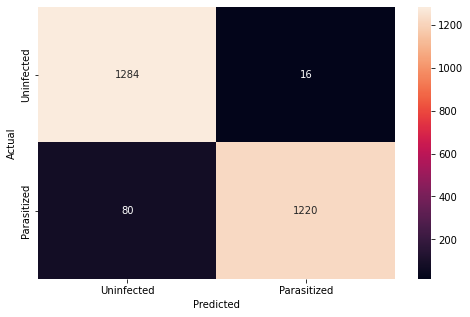

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = SigmoidModel.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [ ]:
def plot_accuracy(history_SigmoidModel):
    N = len(history_SigmoidModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_SigmoidModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_SigmoidModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

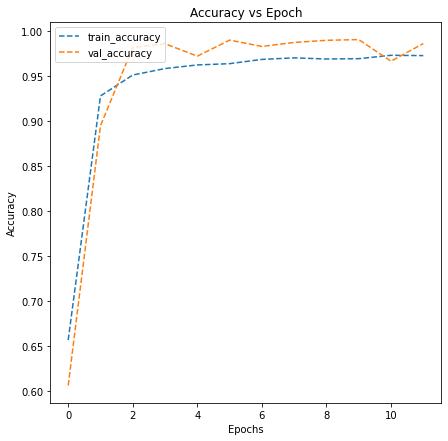

In [ ]:
plot_accuracy(history_SigmoidModel)

#### **Observations and insights:**
- The sigmoid model has 3 sequential 2D convolutional layers to extract features from input images and two fully connected layer with dense neural network as the base model. However, Sigmoid activation function is used for the final output layer instead of Softmax. Regualize with dropout at each layer to avoid overfitting. 
- Total parameters: 1,060,834.
- Model training time: 112 sec
- Model accuracy: 0.9630
- Test accuracy running time: 1 sec
- Precision: 0.94
- Recall: 0.99
- f1-score: 0.96
- Both training and test accuracy converage quickly after 2 epochs and plateau at round 0.96. The training data appears to have a similar accuracy curve as in the base model. However, the validation curve is less stable in the sigmoid model, indicating the Softmax activation at the final output layer results in a more robust model fitting of the test data.



### **4CONVModel**
The Base Model with an additional convolution layers before feeding to the fully connected layers

#### **Importing the required libraries**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

#### **Building the model**
1.   Feature Extraction: 
Building four sequential layers to extract features from input images. For each layer, using 2D convolution with ReLu activation, then Max Pooling to reduce the number of parameters at each layer. 
2.   Classification:
Flattening the matrix into vector and feed it into a dense neural network. With the fully connected layers, combining the features to create the model with sigmoid activation function to classify the outputs as unifected or parasitized. Dropout regualization to avoid overfitting.


 

In [ ]:
#Create sequential model
CONVModel=Sequential()

#Convoltion layer 1 
CONVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
CONVModel.add(MaxPooling2D(pool_size=2))
CONVModel.add(Dropout(0.25))
#Convolution layer 2
CONVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
CONVModel.add(MaxPooling2D(pool_size=2))
CONVModel.add(Dropout(0.25))
#Convolution layer 3
CONVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
CONVModel.add(MaxPooling2D(pool_size=2))
CONVModel.add(Dropout(0.25))
#Convolution layer 4
CONVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
CONVModel.add(MaxPooling2D(pool_size=2))
CONVModel.add(Dropout(0.25))

CONVModel.add(Flatten())

#Fully connected dense layer 1
CONVModel.add(Dense(512,activation="relu"))
CONVModel.add(BatchNormalization())
CONVModel.add(Dropout(0.5))
#Output layer neurons with Softmax activation
CONVModel.add(Dense(2,activation="softmax"))

CONVModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

#### **Compiling the model**

In [ ]:
CONVModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train the model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
%time history_CONVModel=CONVModel.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)


Epoch 1/20
624/624 [==============================] - 10s 15ms/step - loss: 0.5785 - accuracy: 0.6965 - val_loss: 0.4437 - val_accuracy: 0.8722
Epoch 2/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1676 - accuracy: 0.9411 - val_loss: 0.0706 - val_accuracy: 0.9862
Epoch 3/20
624/624 [==============================] - 9s 15ms/step - loss: 0.1235 - accuracy: 0.9554 - val_loss: 0.0750 - val_accuracy: 0.9882
Epoch 4/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1095 - accuracy: 0.9620 - val_loss: 0.0596 - val_accuracy: 0.9834
Epoch 5/20
624/624 [==============================] - 9s 14ms/step - loss: 0.1055 - accuracy: 0.9654 - val_loss: 0.0672 - val_accuracy: 0.9798
Epoch 6/20
624/624 [==============================] - 9s 14ms/step - loss: 0.0989 - accuracy: 0.9686 - val_loss: 0.0760 - val_accuracy: 0.9786
CPU times: user 54.3 s, sys: 4.91 s, total: 59.2 s
Wall time: 55.3 s


#### **Evaluating the model**

<b> Model accuracy on the test data

In [ ]:
%time accuracy_CONVModel = CONVModel.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:', accuracy_CONVModel[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.0612 - accuracy: 0.9823
CPU times: user 905 ms, sys: 89.5 ms, total: 995 ms
Wall time: 32.9 s

 Test_Accuracy: 0.9823076725006104


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



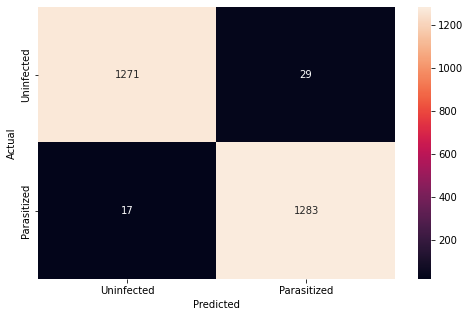

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = CONVModel.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [ ]:
def plot_accuracy(history_CONVModel):
    N = len(history_CONVModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_CONVModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_CONVModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

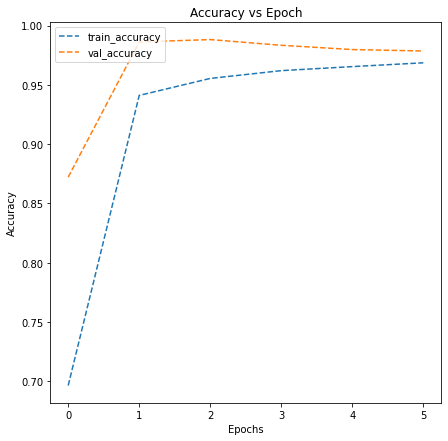

In [ ]:
plot_accuracy(history_CONVModel)

#### **Observations and insights:**
- The 4COMV model has 4 sequential 2D convolutional layers to extract features from input images and two fully connected layer with dense neural network. Softmax activation function is used for the final output layer. Regualize with dropout at each layer to avoid overfitting. 
- Total parameters: 278,530
- Model training time: 59 sec
- Model accuracy: 0.9823
- Test accuracy running time: 0.995 sec
- Precision: 0.99
- Recall: 0.98
- f1-score: 0.98
- Both training and test accuracy converage quickly after 2 epochs and stablize after 5 epochs. The training accuracy plateaus round 0.96, while the validation accuracy plateaus around 0.98. This model also has slightly higher test accuracy and precision than the base model. 
- By adding an additional convolutional layer, we also reduced the total parameters significantly - this is improtant for the production code to simplify the model without overfitting. 


### **Data Transformation - HSV**
- Convert RGB to HSV of Images using OpenCV
- Build a model with 4 CONV and batch normalization



**Converting RGB to HSV**

In [ ]:
import cv2
gfx=[]   # to hold the HSV image array
for i in np.arange(0,train_images.shape[0],1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  gfx.append(a)
gfx=np.array(gfx)

gfx_test=[]   # to hold the HSV image array
for i in np.arange(0,test_images.shape[0],1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  gfx_test.append(a)
gfx_test=np.array(gfx_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

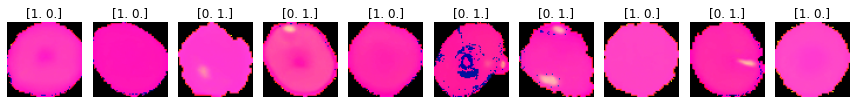

In [ ]:
viewimage=np.random.randint(1,train_images.shape[0],10)   
fig,ax=plt.subplots(1,10,figsize=(12,12))
for t,i in zip(range(10),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

####<b> Import the required libraries

In [ ]:
#Clear backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fix the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Build the model

In [ ]:
#Create a sequential model
HSVModel=Sequential()

#Layer 1 
HSVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
HSVModel.add(MaxPooling2D(pool_size=2))
HSVModel.add(Dropout(0.2))

#Layer 2
HSVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
HSVModel.add(MaxPooling2D(pool_size=2))
HSVModel.add(Dropout(0.2))

#Layer 3
HSVModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
HSVModel.add(MaxPooling2D(pool_size=2))
HSVModel.add(Dropout(0.2))

#Layer 4
HSVModel.add(Conv2D(filters=16, kernel_size=2, padding="same"))
HSVModel.add(LeakyReLU(0.1))
HSVModel.add(MaxPool2D(pool_size=(2, 2)))

HSVModel.add(Flatten())

HSVModel.add(Dense(512,activation="relu"))
HSVModel.add(BatchNormalization())
HSVModel.add(Dropout(0.4))
HSVModel.add(Dense(2,activation="softmax"))

HSVModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compile the model

In [ ]:
HSVModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Use Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
%time history_HSVModel = HSVModel.fit(gfx,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 10s 15ms/step - loss: 0.7120 - accuracy: 0.6085 - val_loss: 1.0077 - val_accuracy: 0.0407
Epoch 2/20
624/624 [==============================] - 9s 14ms/step - loss: 0.6694 - accuracy: 0.6260 - val_loss: 1.2222 - val_accuracy: 0.0034
Epoch 3/20
624/624 [==============================] - 9s 14ms/step - loss: 0.6610 - accuracy: 0.6316 - val_loss: 0.9380 - val_accuracy: 0.0278
Epoch 4/20
624/624 [==============================] - 9s 14ms/step - loss: 0.6572 - accuracy: 0.6351 - val_loss: 0.4745 - val_accuracy: 0.9746
Epoch 5/20
624/624 [==============================] - 9s 15ms/step - loss: 0.6570 - accuracy: 0.6333 - val_loss: 0.6616 - val_accuracy: 0.7923
Epoch 6/20
624/624 [==============================] - 9s 14ms/step - loss: 0.6533 - accuracy: 0.6362 - val_loss: 0.7212 - val_accuracy: 0.5272
CPU times: user 54.7 s, sys: 5.18 s, total: 59.9 s
Wall time: 55.7 s


####<b> Evaluate the model on test data

In [ ]:
%time accuracy_HSVModel = HSVModel.evaluate(gfx_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:', accuracy_HSVModel[1])

82/82 [==============================] - 1s 8ms/step - loss: 0.6868 - accuracy: 0.5569
CPU times: user 1.08 s, sys: 144 ms, total: 1.23 s
Wall time: 59.3 s

 Test_Accuracy: 0.5569230914115906


<b> Plot the confusion matrix

              precision    recall  f1-score   support

           0       0.59      0.36      0.45      1300
           1       0.54      0.75      0.63      1300

    accuracy                           0.56      2600
   macro avg       0.57      0.56      0.54      2600
weighted avg       0.57      0.56      0.54      2600



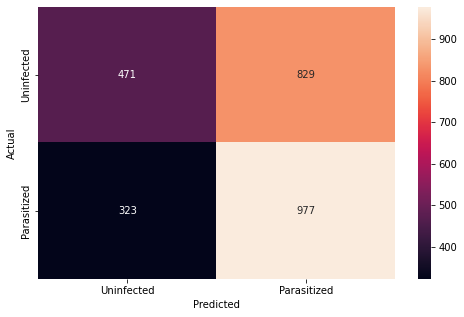

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = HSVModel.predict(gfx_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plot the train and validation curves

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history_HSVModel):
    N = len(history_HSVModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_HSVModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_HSVModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

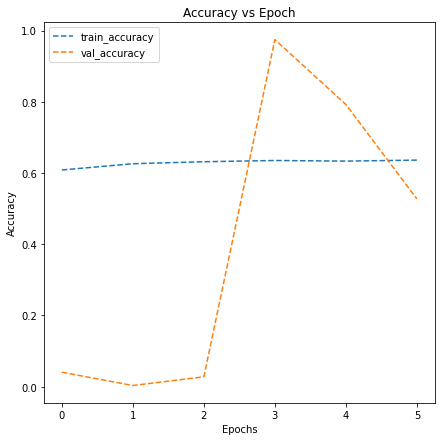

In [ ]:
plot_accuracy(history_HSVModel)

#### **Observations and insights:**
- The HSV model has 4 sequential 2D convolutional layers to extract features from input images and two fully connected layer with dense neural network. Softmax activation function is used for the final output layer. Regualize with dropout at each layer to avoid overfitting. 
- Total parameters: 145,394
- Model training time: 60 sec
- Model accuracy: 0.5569
- Test accuracy running time: 1.23 sec
- Precision: 0.59
- Recall: 0.36
- f1-score: 0.45
- HSV data transformation yeilded a model with much worse training and validation accuracy as well as precision, recall, and f1-score on the test dataset. 
- HSV transformation is not as unseful as expected, perhaps due to the non-homogenous nature of the color matric staining, where cells in the same class might have more red than blue. 

###<b>Data Augmentation

In [ ]:
#Clear backend
from tensorflow.keras import backend
backend.clear_session()
#Fix the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Use image data generator

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Use ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
val_datagen = ImageDataGenerator()

#Flow training images using train_datagen generator
train_generator = train_datagen.flow(x = train_images, y = train_labels, batch_size=64, seed=42, shuffle=True)     

#Flow test images using val_datagen generator
val_generator = val_datagen.flow(x= test_images, y = test_labels, batch_size=64, seed=42, shuffle=True)

####<B>Visualize Augmented images

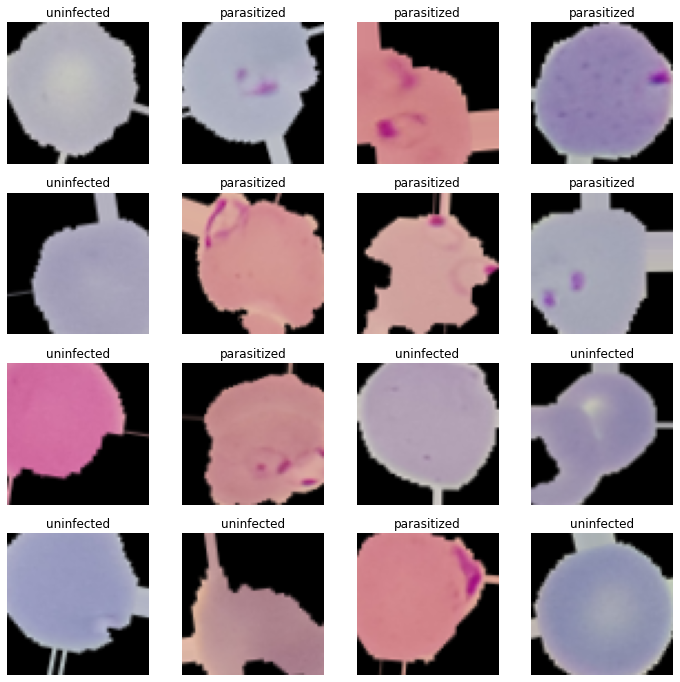

In [ ]:
#Create an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plot 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(12, 12)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

####<b>Build the model

In [ ]:
#Create a sequential model
AUGModel=Sequential()

#Layer 1 
AUGModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
AUGModel.add(MaxPooling2D(pool_size=2))
AUGModel.add(Dropout(0.2))

#Layer 2
AUGModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
AUGModel.add(MaxPooling2D(pool_size=2))
AUGModel.add(Dropout(0.2))

#Layer 3
AUGModel.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
AUGModel.add(MaxPooling2D(pool_size=2))
AUGModel.add(Dropout(0.2))

#Layer 4
AUGModel.add(Conv2D(filters=16, kernel_size=2, padding="same"))
AUGModel.add(LeakyReLU(0.1))
AUGModel.add(MaxPool2D(pool_size=(2, 2)))

AUGModel.add(Flatten())

AUGModel.add(Dense(512,activation="relu"))
AUGModel.add(BatchNormalization())
AUGModel.add(Dropout(0.4))
AUGModel.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

#Use Adam as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

AUGModel.compile(loss='binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
AUGModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [ ]:
%time history_AUGModel = AUGModel.fit(train_generator, validation_data=val_generator, batch_size=32,callbacks=callbacks, epochs=20,verbose=1)

Epoch 1/20
390/390 [==============================] - 43s 106ms/step - loss: 0.6357 - accuracy: 0.6510 - val_loss: 0.5207 - val_accuracy: 0.8188
Epoch 2/20
390/390 [==============================] - 41s 104ms/step - loss: 0.2180 - accuracy: 0.9227 - val_loss: 0.1240 - val_accuracy: 0.9565
Epoch 3/20
390/390 [==============================] - 41s 104ms/step - loss: 0.1648 - accuracy: 0.9438 - val_loss: 0.1238 - val_accuracy: 0.9542
Epoch 4/20
390/390 [==============================] - 41s 105ms/step - loss: 0.1525 - accuracy: 0.9498 - val_loss: 0.1307 - val_accuracy: 0.9535
Epoch 5/20
390/390 [==============================] - 41s 104ms/step - loss: 0.1434 - accuracy: 0.9529 - val_loss: 0.1416 - val_accuracy: 0.9515
CPU times: user 3min 54s, sys: 5.67 s, total: 4min
Wall time: 4min 6s


####<B>Evaluating the model

In [ ]:
#Evaluate the model on test data
%time accuracy_AUGModel = AUGModel.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:', accuracy_AUGModel[1])

82/82 [==============================] - 1s 8ms/step - loss: 0.1416 - accuracy: 0.9515
CPU times: user 1.14 s, sys: 123 ms, total: 1.26 s
Wall time: 45.6 s

 Test_Accuracy: 0.9515384435653687


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



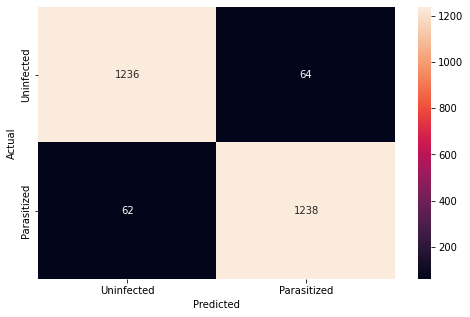

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred3 = AUGModel.predict(test_images)
pred3 = np.argmax(pred3,axis = 1) 
y_true3 = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true3,pred3))

#Plotting the heatmap using confusion matrix
cm3 = confusion_matrix(y_true3,pred3)
plt.figure(figsize=(8,5))
sns.heatmap(cm3, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plot the train and validation accuracy

In [ ]:
#Function to plot train and validation accuracy 
def plot_accuracy(history_HSVModel):
    N = len(history_AUGModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_AUGModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_AUGModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

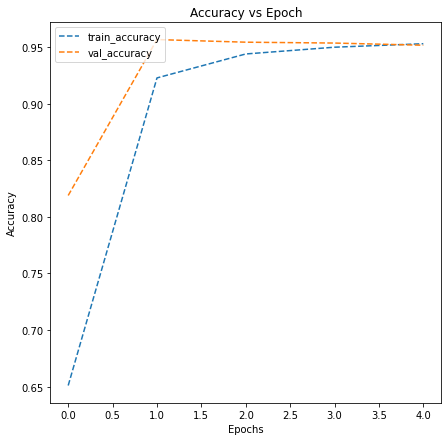

In [ ]:
#Plot the accuracies
plot_accuracy(history_AUGModel)

#### **Observations and insights:**
- The model with data augmentation has 4 sequential 2D convolutional layers to extract features from input images and two fully connected layer with dense neural network. Softmax activation function is used for the final output layer. Regualize with dropout at each layer to avoid overfitting. 
- Total parameters: 145,394
- Model training time: 240 sec
- Model accuracy: 0.95
- Test accuracy running time: 1.26 sec
- Precision: 0.95
- Recall: 0.95
- f1-score: 0.95
- Data augmentation did not improve the 4CONV model performance based on the test accuracy, precision, recall, and f1-score. One possible explaination is that some cells in the transformed images are cropped or have other artifacts introduced due processing. Also, the high test accuracy, precision, recalls, and f1-score in the base model suggest that we have sufficiently large training dataset to build a robust model.

### **Pre-trained model (VGG16)**

In [ ]:
#Clear backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', pooling='max', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

#Flatten the output from the 5th block of the VGG16 model
x = Flatten()(transfer_layer.output) 
x = Dense(256, activation='relu')(x)

#Add a dense layer with 128 neurons
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
# Add a dense layer with 64 neurons
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

pred = Dense(2, activation='softmax')(x)

#Initializing the model
VGGModel = Model(vgg.input, pred) 

In [ ]:
VGGModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

####<b>Compiling the model

In [ ]:
#Compile the model 
VGGModel.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0005),
              metrics=['accuracy'])

<b>Use Callbacks

In [ ]:
#Add Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
#Fit the model and run the model for 10 epochs
#%time history_VGGModel = VGGModel.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=10, verbose=1)

%time history_VGGModel = VGGModel.fit(train_images,train_labels,batch_size=32,validation_split=0.2,epochs=10, verbose=1)


Epoch 1/10
624/624 [==============================] - 36s 57ms/step - loss: 0.1540 - accuracy: 0.9416 - val_loss: 0.2396 - val_accuracy: 0.8982
Epoch 2/10
624/624 [==============================] - 30s 49ms/step - loss: 0.1460 - accuracy: 0.9467 - val_loss: 0.4326 - val_accuracy: 0.7943
Epoch 3/10
624/624 [==============================] - 30s 49ms/step - loss: 0.1434 - accuracy: 0.9454 - val_loss: 0.0767 - val_accuracy: 0.9736
Epoch 4/10
624/624 [==============================] - 35s 56ms/step - loss: 0.1405 - accuracy: 0.9465 - val_loss: 0.2266 - val_accuracy: 0.9151
Epoch 5/10
624/624 [==============================] - 31s 49ms/step - loss: 0.1333 - accuracy: 0.9512 - val_loss: 0.2095 - val_accuracy: 0.9143
Epoch 6/10
624/624 [==============================] - 31s 49ms/step - loss: 0.1299 - accuracy: 0.9512 - val_loss: 0.2528 - val_accuracy: 0.8948
Epoch 7/10
624/624 [==============================] - 35s 57ms/step - loss: 0.1285 - accuracy: 0.9514 - val_loss: 0.0933 - val_accuracy:

####<b>Evaluate the model

In [ ]:
#Evaluate the model on test data
%time accuracy_VGGModel = VGGModel.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy', accuracy_VGGModel[1])


82/82 [==============================] - 3s 41ms/step - loss: 0.1530 - accuracy: 0.9388
CPU times: user 1.35 s, sys: 176 ms, total: 1.52 s
Wall time: 3.49 s

 Test_Accuracy 0.9388461709022522


<b>Plot the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1300
           1       0.91      0.97      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



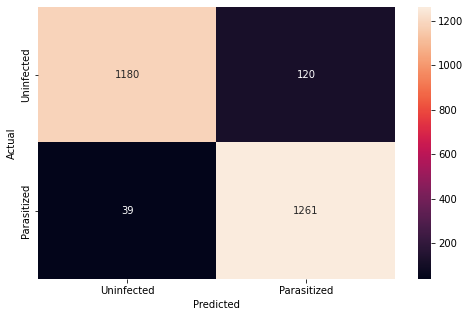

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred4 = VGGModel.predict(test_images)
pred4 = np.argmax(pred4,axis = 1) 
y_true4 = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true4,pred4))

#Plotting the heatmap using confusion matrix
cm4 = confusion_matrix(y_true4,pred4)
plt.figure(figsize=(8,5))
sns.heatmap(cm4, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plot the train and validation accuracy

In [ ]:
#Function to plot train and validation accuracy 
def plot_accuracy(history_VGGModel):
    N = len(history_VGGModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_VGGModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_VGGModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

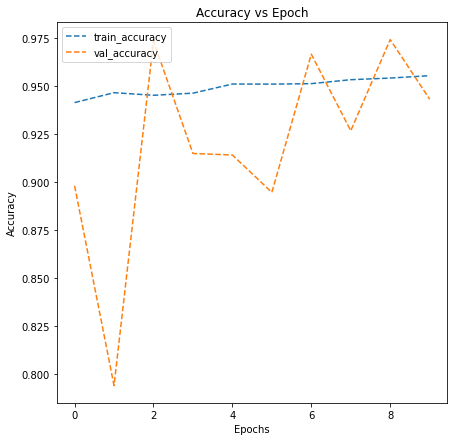

In [ ]:
# plotting the accuracies
plot_accuracy(history_VGGModel)

#### **Observations and insights:**
- The VGG model using pre-trained VGG16 model with additional classification layers 
- Total parameters: 15,280,770
- Model training time: 173 sec
- Model accuracy: 0.94
- Test accuracy running time: 1.52 sec
- Precision: 0.97
- Recall: 0.91
- f1-score: 0.94
- With Callbacks, model fitting stopped before the training accuracy stablizes. Remove Callbacks and run model fitting to full 10 epochs resulted in better performance.  
- The training curve is as expected - the accuracy improves as the number of epochs increases; however, the validation accuracy fluctuates over the iterations. This observation suggests potential model fitting due to the large number of parameters inherent to the VGG16 pretrained model.

### **Pre-trained model (ResNet)**

In [ ]:
#Clear backend
from tensorflow.keras import backend
backend.clear_session()
#Fix the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras import Model

ResNet = ResNet101V2(include_top=False, weights='imagenet', input_shape=None, pooling='max', classifier_activation='softmax')
ResNet.summary()

171327488/171317808 [==============================] - 2s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                     

In [ ]:
transfer_layer = ResNet.get_layer('max_pool')
ResNet.trainable=False

# Add classification layers on top of it  
#Flatten the output of the ResNet101V2 model
x = Flatten()(transfer_layer.output) 
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

pred = Dense(2, activation='softmax')(x)

#Initialize the model
ResNetModel = Model(ResNet.input, pred)

ResNetModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

####<b>Compile the model

In [ ]:
#Compile the model 
ResNetModel.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0005),
              metrics=['accuracy'])

<b> using callbacks

In [ ]:
#Add Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
#Fit the model and run the model for 10 epochs
#%time history_ResNetModel = ResNetModel.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=10, verbose=1)
%time history_ResNetModel = ResNetModel.fit(train_images,train_labels,batch_size=32,validation_split=0.2,epochs=10, verbose=1)


Epoch 1/10
624/624 [==============================] - 58s 93ms/step - loss: 0.1460 - accuracy: 0.9400 - val_loss: 0.2508 - val_accuracy: 0.9030
Epoch 2/10
624/624 [==============================] - 56s 90ms/step - loss: 0.1347 - accuracy: 0.9438 - val_loss: 0.3158 - val_accuracy: 0.8738
Epoch 3/10
624/624 [==============================] - 57s 91ms/step - loss: 0.1198 - accuracy: 0.9519 - val_loss: 0.2161 - val_accuracy: 0.9167
Epoch 4/10
624/624 [==============================] - 56s 90ms/step - loss: 0.1110 - accuracy: 0.9558 - val_loss: 0.2495 - val_accuracy: 0.9024
Epoch 5/10
624/624 [==============================] - 57s 91ms/step - loss: 0.0976 - accuracy: 0.9616 - val_loss: 0.3070 - val_accuracy: 0.8896
Epoch 6/10
624/624 [==============================] - 56s 90ms/step - loss: 0.0971 - accuracy: 0.9624 - val_loss: 0.2003 - val_accuracy: 0.9279
Epoch 7/10
624/624 [==============================] - 56s 90ms/step - loss: 0.0847 - accuracy: 0.9662 - val_loss: 0.3066 - val_accuracy:

####<b> Evaluating the model

In [ ]:
#Evaluate the model on test data
%time accuracy_ResNetModel = ResNetModel.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:', accuracy_ResNetModel[1])


82/82 [==============================] - 6s 73ms/step - loss: 0.3448 - accuracy: 0.8904
CPU times: user 3.11 s, sys: 264 ms, total: 3.37 s
Wall time: 6.19 s

 Test_Accuracy: 0.8903846144676208


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1300
           1       0.87      0.92      0.89      1300

    accuracy                           0.89      2600
   macro avg       0.89      0.89      0.89      2600
weighted avg       0.89      0.89      0.89      2600



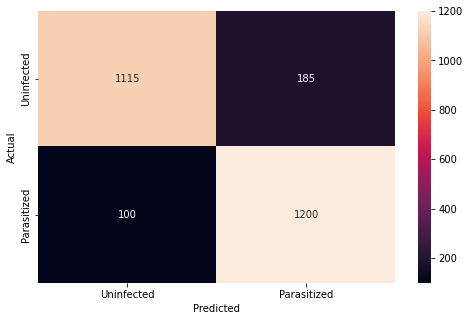

In [ ]:
#Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred4 = ResNetModel.predict(test_images)
pred4 = np.argmax(pred4,axis = 1) 
y_true4 = np.argmax(test_labels,axis = 1)

#Print the classification report
print(classification_report(y_true4,pred4))

#Plot the heatmap using confusion matrix
cm4 = confusion_matrix(y_true4,pred4)
plt.figure(figsize=(8,5))
sns.heatmap(cm4, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plot the train and validation accuracy

In [ ]:
#Function to plot train and validation accuracy 
def plot_accuracy(history_ResNetModel):
    N = len(history_ResNetModel.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history_ResNetModel.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history_ResNetModel.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

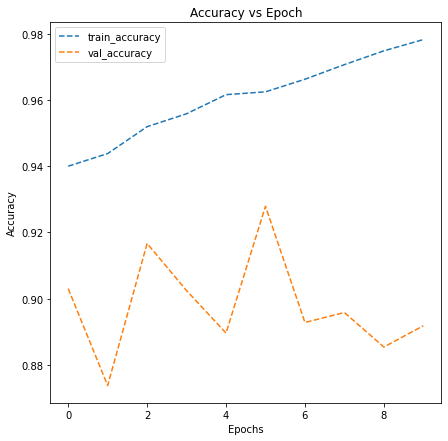

In [ ]:
#Plot the accuracies
plot_accuracy(history_ResNetModel)

#### **Observations and insights:**
- The ResNet model using pre-trained ResNet 101 V2 with additional classification layers 
- Total parameters: 43,185,282
- Model training time: 173 sec
- Model accuracy: 0.89
- Test accuracy running time: 3.37 sec
- Precision: 0.92
- Recall: 0.86
- f1-score: 0.89
- As observed in VGG16 model, model fitting stopped before the training accuracy stablizes with Callbacks. Remove Callbacks and run model fitting to full 10 epochs resulted in better performance.  
- The accuracy in the training curve continues to increase and did not converge for the first 10 epochs. The validation accuracy is lower than the training fluctuates between 0.87 and 0.93. This observation also suggests potential model fitting due to the large number of parameters inherent to the ResNet pretrained model.

###<b> Observations and Conclusions drawn from the final model:
- Using Softmax activation function at the output layer results in slightly better model. 
- 4CONV Model (the base model with an additional convolutional layer) is the best performing model with the test accuracy of 0.98, precision of 0.99, recall of 0.98, and f1-score of 0.98. This simple model out-performs the pretrained models (VGG16 and ResNet 101). 
- Transforming RGB images to HSV images yeilded the worst performing model amongst the models tested in the project. 
- Data augmentation using ImageDataGenerator did not improve the performance of the 4CONV model either. 
- Due to the nature of the problem, where there is a clear distinction between the uninfected and cells infected with parasites - the parasitized cells have patches of parasites stained in darker purple. This is a rather straightforward binary classification problem using low resolution images. 


